prototyping of the interpolation data generation

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import random

import tensorflow as tf
import numpy as np
#import cmsisdsp as dsp
import random

#import sys
#sys.path.append('/home/mat/dev/cached_dilated_causal_convolutions/') 

# from cmsisdsp_py_version.block import Block
# from cmsisdsp_py_version.keras_model import create_dilated_model, create_strided_model
# from cmsisdsp_py_version.cached_block_model import CachedBlockModel, Regression
# from cmsisdsp_py_version.rolling_cache import RollingCache


In [32]:
def parse(fname, w0n, w1n, w2n):
    df_w = pd.read_csv(fname, sep=' ', names=['tri', w0n, w1n, w2n])
    df_w['n'] = range(len(df_w))
    df_l = df_w.melt(id_vars='n', value_vars=['tri', w0n, w1n, w2n])
    return df_w, df_l

D = '/data2/cached_dilated_causal_convolutions/2d_embed_interp/low_freq_range/24kHz'
tsrq_df_w, tsrq_df_l = parse(f"{D}/tri_sine_ramp_square.ssv", 'sine', 'ramp', 'square')
tqzs_df_w, tqzs_df_l = parse(f"{D}/tri_square_zigzag_sine.ssv", 'square', 'zigzag', 'sine')

tsrq_a = tsrq_df_w.to_numpy()
tqzs_a = tqzs_df_w.to_numpy()


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

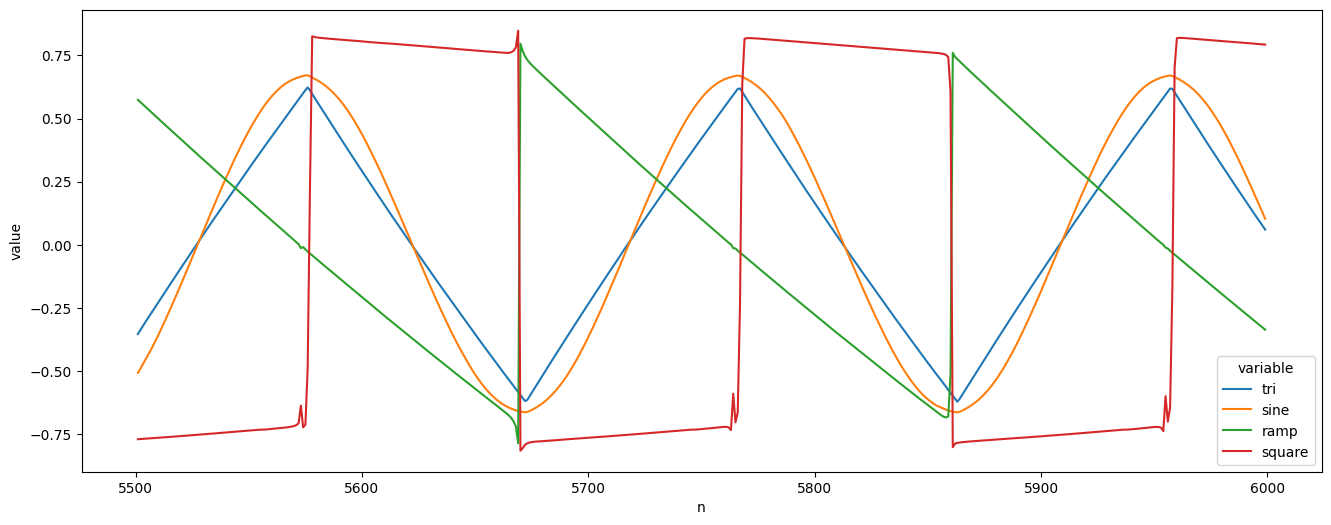

In [37]:
plt.figure(figsize=(16, 6))
offset = 5500
width = 500
df = tsrq_df_l
window = (df['n']>offset) & (df['n']<offset+width)
sns.lineplot(df[window], x='n', y='value', hue='variable')

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

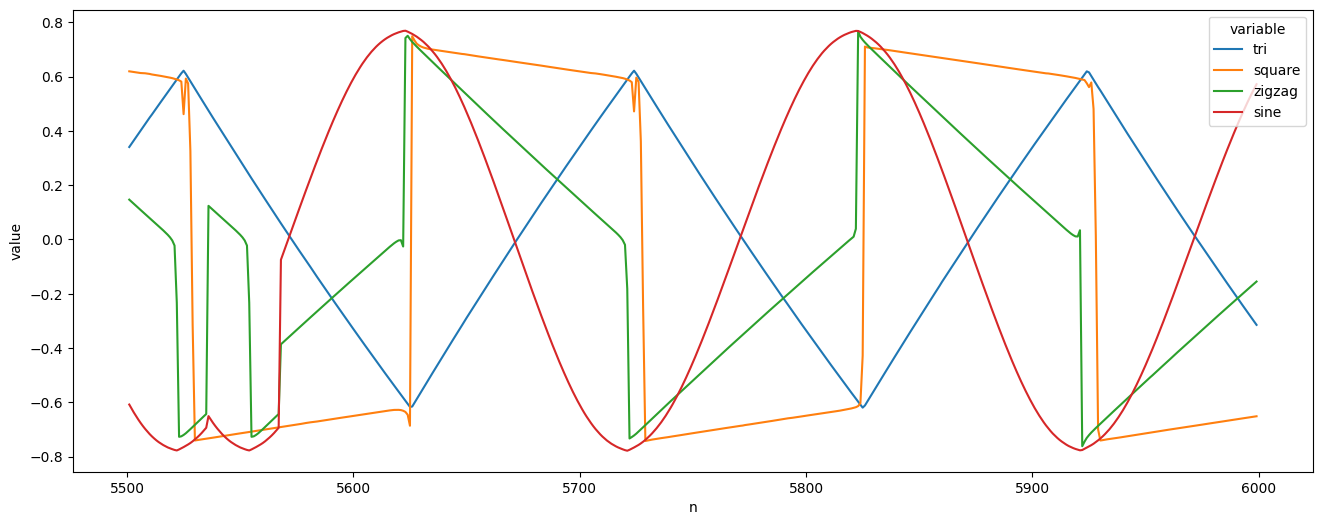

In [38]:
plt.figure(figsize=(16, 6))
offset = 5500
width = 500
df = tqzs_df_l
window = (df['n']>offset) & (df['n']<offset+width)
sns.lineplot(df[window], x='n', y='value', hue='variable')

In [39]:
tqzs_a[:10]

array([[-0.52596451,  0.69967654,  0.6723888 ,  0.71498944,  0.        ],
       [-0.51179434,  0.69910195,  0.66407584,  0.7060592 ,  1.        ],
       [-0.49788832,  0.69797587,  0.65571693,  0.69638803,  2.        ],
       [-0.4839344 ,  0.69709107,  0.64744902,  0.68615507,  3.        ],
       [-0.46967267,  0.696064  ,  0.63927386,  0.67523981,  4.        ],
       [-0.45576979,  0.6947303 ,  0.63091539,  0.66333318,  5.        ],
       [-0.44182515,  0.69360755,  0.62268448,  0.65080621,  6.        ],
       [-0.42785024,  0.6924231 ,  0.61439302,  0.63742925,  7.        ],
       [-0.41405917,  0.69108128,  0.60627296,  0.6234615 ,  8.        ],
       [-0.40013885,  0.68983699,  0.59794163,  0.60866234,  9.        ]])

now we code picking a random point

In [78]:
def wave_to_embed_pt(w):
    return {
        'sine': np.array([-1, -1]),
        'ramp': np.array([-1, 1]),
        'square': np.array([1, 1]),
        'zigzag': np.array([1, -1])
    }[w]
    
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def parse(fname, w0n, w1n, w2n):
    df_w = pd.read_csv(fname, sep=' ', names=['tri', w0n, w1n, w2n])
    df_w['n'] = range(len(df_w))
    #df_l = df_w.melt(id_vars='n', value_vars=['tri', w0n, w1n, w2n])
    return df_w.to_numpy() #, df_l
    
class WaveData(object):
    
    def __init__(self, wave0, wave1, data, pad_to_size, rescaling_factor):
        assert data.shape[1] == 3  # triangle + 2 waves
        self.wave0 = wave0
        self.wave1 = wave1
        self.embed_pt0 = wave_to_embed_pt(wave0)
        self.embed_pt1 = wave_to_embed_pt(wave1)
        self.data = data
        self.pad_to_size = pad_to_size
        self.rescaling_factor = rescaling_factor

    def sample(self, alpha, seq_len):
        
        # sample rows
        max_offset = len(self.data) - seq_len - 1
        random_offset = random.randint(0, max_offset)
        sample = self.data[random_offset:(random_offset+seq_len)]
        #print("sample", sample.shape)
        
        # interpolate sample
        interpolated_sample = (alpha * sample[:, 1]) + ((1-alpha) * sample[:, 2])
        
        # smooth with rolling average; can have some sharp boundaries
        # note: we need to pad to restore length ( do so with first element )
        N = 10
        interpolated_sample = moving_average(interpolated_sample, n=N)
        interpolated_sample = np.concatenate([[interpolated_sample[0]] * (N-1), interpolated_sample])

        # interpolate the embed points with the same alphas
        #print("self.embed_pt0", self.embed_pt0)
        #print("self.embed_pt1", self.embed_pt1)
        #print("alpha", alpha)
        interpolated_embed_pt = ( alpha * self.embed_pt0) + ((1-alpha) * self.embed_pt1)
        #print("interpolated_embed_pt", interpolated_embed_pt)
        interpolated_e0, interpolated_e1 = interpolated_embed_pt
        
        x = np.zeros((len(sample), self.pad_to_size), dtype=float)
        x[:, 0] = sample[:, 0] * self.rescaling_factor
        x[:, 1] = interpolated_e0 * self.rescaling_factor
        x[:, 2] = interpolated_e1 * self.rescaling_factor
        
        y = np.zeros((len(sample), self.pad_to_size), dtype=float)
        y[:, 0] = interpolated_sample * self.rescaling_factor
        
        return x, y        

    def as_tf_dataset(self, seq_len, max_samples):

        def gen():            
            num_samples_emitted = 0
            while True:
                yield self.sample(alpha=0.0, seq_len=seq_len)
                yield self.sample(alpha=1.0, seq_len=seq_len)
                yield self.sample(alpha=random.random(), seq_len=seq_len)
                num_samples_emitted += 3
                if num_samples_emitted > max_samples:
                    return
        
        return tf.data.Dataset.from_generator(
            gen, output_signature=(
                tf.TensorSpec(shape=(seq_len, self.pad_to_size), dtype=tf.float32),
                tf.TensorSpec(shape=(seq_len, self.pad_to_size), dtype=tf.float32)))


class Embed2DInterpolatedWaveFormData(object):
    
    def __init__(self,
                root_dir,
                rescaling_factor=1,
                pad_size=8):

        #D = 
        tsrq_a = parse(f"{root_dir}/tri_sine_ramp_square.ssv", 'sine', 'ramp', 'square')
        tqzs_a = parse(f"{root_dir}/tri_square_zigzag_sine.ssv", 'square', 'zigzag', 'sine')

        self.tsr = WaveData('sine', 'ramp',   tsrq_a[:,[0,1,2]], 
                            pad_to_size=pad_size, rescaling_factor=rescaling_factor)
        self.trq = WaveData('ramp', 'square', tsrq_a[:,[0,2,3]], 
                            pad_to_size=pad_size, rescaling_factor=rescaling_factor)                            
        self.tqz = WaveData('square', 'zigzag', tqzs_a[:,[0,1,2]], 
                            pad_to_size=pad_size, rescaling_factor=rescaling_factor)
        self.tzs = WaveData('zigzag', 'sine', tqzs_a[:,[0,2,3]], 
                            pad_to_size=pad_size, rescaling_factor=rescaling_factor)

        self.all_wave_data = [ self.tsr, self.trq, self.tqz, self.tzs ]

    def tf_dataset_for_split(self, split, seq_len, max_samples, waves=None):

        assert waves == None, "TODO"
        
        sampled_ds = tf.data.Dataset.sample_from_datasets(
            [wd.as_tf_dataset(seq_len, max_samples) for wd in self.all_wave_data]
        )

        if split == 'train':
            sampled_ds = sampled_ds.shuffle(1000)

        sampled_ds = sampled_ds.batch(1 if split=='test' else 64)

        return sampled_ds.prefetch(tf.data.AUTOTUNE)

        
def plot(x, y, fname):
    assert x.shape == y.shape    
    assert x.shape[1] == 8, x.shape
    df = pd.DataFrame()
    df['x'] = x[:,0]
    df['e0'] = x[:,1]
    df['e1'] = x[:,2]
    df['y'] = y[:,0]
    df['n'] = range(len(df))
    wide_df = pd.melt(df, id_vars=['n'], value_vars=['x', 'e0', 'e1', 'y'])
    plt.figure(figsize=(20, 10))
    p = sns.lineplot(wide_df, x='n', y='value', hue='variable')
    p.set_ylim((-2, 2))
    plt.savefig(fname)
    plt.clf()


data = Embed2DInterpolatedWaveFormData(
    root_dir='/data2/cached_dilated_causal_convolutions/2d_embed_interp/low_freq_range/24kHz')

for x, y in data.tf_dataset_for_split('train', seq_len=500, max_samples=100):    
    print(x.shape, y.shape)
    for b in range(len(x)):
        e0, e1 = x[b,0,1], x[b,0,2]
        fname = f"foo_{b:03d}.{e0}_{e1}.png"
        print(b, fname)
        plot(x[b], y[b], fname)
    break



(64, 500, 8) (64, 500, 8)
0 foo_000.1.0_1.0.png
1 foo_001.-1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

2 foo_002.0.9364009499549866_1.0.png
3 foo_003.1.0_0.9369502663612366.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

4 foo_004.1.0_0.1751549243927002.png
5 foo_005.-1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

6 foo_006.-1.0_1.0.png
7 foo_007.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

8 foo_008.-1.0_-0.8026245832443237.png
9 foo_009.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

10 foo_010.1.0_1.0.png
11 foo_011.0.8933359384536743_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

12 foo_012.0.6044210195541382_-1.0.png
13 foo_013.-1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

14 foo_014.-0.8859142065048218_1.0.png
15 foo_015.-1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

16 foo_016.1.0_1.0.png
17 foo_017.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

18 foo_018.-1.0_0.5702078938484192.png
19 foo_019.-1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

20 foo_020.-1.0_-0.2836369574069977.png
21 foo_021.1.0_-1.0.png


/tmp/ipykernel_15525/2867926872.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldc

22 foo_022.-1.0_0.4174024760723114.png
23 foo_023.1.0_0.0866599828004837.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

24 foo_024.1.0_1.0.png
25 foo_025.-1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

26 foo_026.-0.7629700899124146_-1.0.png
27 foo_027.-1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

28 foo_028.1.0_1.0.png
29 foo_029.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

30 foo_030.0.07934467494487762_1.0.png
31 foo_031.-1.0_-0.752082109451294.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

32 foo_032.1.0_-1.0.png
33 foo_033.-1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

34 foo_034.1.0_1.0.png
35 foo_035.1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

36 foo_036.-1.0_1.0.png
37 foo_037.-0.06461536884307861_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

38 foo_038.-1.0_-1.0.png
39 foo_039.-0.11920544505119324_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

40 foo_040.1.0_1.0.png
41 foo_041.1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

42 foo_042.1.0_0.4054372310638428.png
43 foo_043.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

44 foo_044.1.0_1.0.png
45 foo_045.1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

46 foo_046.1.0_1.0.png
47 foo_047.-1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

48 foo_048.-1.0_-1.0.png
49 foo_049.-1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

50 foo_050.1.0_1.0.png
51 foo_051.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

52 foo_052.1.0_0.2597558796405792.png
53 foo_053.-1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

54 foo_054.1.0_-1.0.png
55 foo_055.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

56 foo_056.1.0_-1.0.png
57 foo_057.1.0_-0.14982904493808746.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

58 foo_058.1.0_1.0.png
59 foo_059.1.0_-1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

60 foo_060.-1.0_-1.0.png
61 foo_061.-1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

62 foo_062.1.0_1.0.png
63 foo_063.1.0_1.0.png


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [50]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [42]:
tzsr = tzsr_df_w.to_numpy()
tzsr[:10]

NameError: name 'tzsr_df_w' is not defined

In [385]:

wave_to_embed_pt = { 
    's': [-1, -1],
    'r': [-1, 1],
    'z': [1, 1],
    'q': [1, -1]
}

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
class WaveData(object):
    
    def __init__(self, waves, df, pad_to_size):
        self.waves = waves
        self.wave_to_column = { name: idx for idx, name in enumerate(waves) } 
        self.df = df
        self.pad_to_size = pad_to_size

    def _random_interpolation_from_sample(self, sample):
        
        interp_waves = self.waves[1:]
        random.shuffle(interp_waves)
#        print("interp_waves", interp_waves)

        # choose alpha for interps
        alpha1 = random.random()
        alpha2 = random.random()
#        print("alphas", alpha1, alpha2)

        # interpolate samples
        # TODO: constant power cross fade would be better here, otherwise we're getting
        #       an amplitude drop
        interp_columns = [self.wave_to_column[w] for w in interp_waves]
#        print("interp_columns", interp_columns)
        interpolated_samples = ( alpha1 * sample[:, interp_columns[0]]) + ((1-alpha1) * sample[:, interp_columns[1]])
        interpolated_samples = ( alpha2 * sample[:, interp_columns[2]]) + ((1-alpha2) * interpolated_samples)
        
        # smooth with rolling average; can have some sharp boundaries
        # note: we need to pad to restore length ( do so with first element )
        N = 10
        interpolated_samples = moving_average(interpolated_samples, n=N)        
        interpolated_samples = np.concatenate([[interpolated_samples[0]] * (N-1), interpolated_samples])
        
        # interpolate the embed points with the same alphas
        embed_pts = [np.array(wave_to_embed_pt[w]) for w in interp_waves]
#        print("interp_pts", interp_pts)
        interpolated_embed_pt = ( alpha1 * embed_pts[0]) + ((1-alpha1) * embed_pts[1])
#        print("interpolated_embed_pt", interpolated_embed_pt)
        interpolated_embed_pt = ( alpha2 * embed_pts[2]) + ((1-alpha2) * interpolated_embed_pt)
#        print("interpolated_embed_pt", interpolated_embed_pt)

        e0 = interpolated_embed_pt[0]  # e0
        e1 = interpolated_embed_pt[1]  # e1
        sy = interpolated_samples     
       
        return e0, e1, sy

    
    def _random_single_wave(self, sample):
        
        random_wave = random.choice(self.waves[1:])
        random_wave_col = self.wave_to_column[random_wave]
        embed_pt = wave_to_embed_pt[random_wave]
                
        e0 = embed_pt[0]   # e0
        e1 = embed_pt[1]   # e1
        sy = sample[:, random_wave_col]        
        
        return e0, e1, sy

    
    def sample(self, random_interpolation, seq_len):
        
        max_offset = len(self.df) - seq_len - 1
        random_offset = random.randint(0, max_offset)
        sample = self.df[random_offset:(random_offset+seq_len)]
        
        if random_interpolation:
            # interpolate randomly between the three waves
            e0, e1, sy = self._random_interpolation_from_sample(sample)            
        else:
            # just pick one of the waves to emit
            e0, e1, sy = self._random_single_wave(sample)

        x = np.zeros((len(sample), self.pad_to_size), dtype=float)
        x[:, 0] = sample[:, 0]
        x[:, 1] = e0
        x[:, 2] = e1
        y = np.zeros((len(sample), self.pad_to_size), dtype=float)  
        y[:, 0] = sy
        
        return x, y        

def parse(fname, w0n, w1n, w2n):
    df_w = pd.read_csv(fname, sep=' ', names=['tri', w0n, w1n, w2n])
    df_w['n'] = range(len(df_w))
    df_l = df_w.melt(id_vars='n', value_vars=['tri', w0n, w1n, w2n])
    return df_w, df_l

tsrq_df_w, tsrq_df_l = parse('../datalogger_firmware/tri_sine_ramp_square.ssv', 'sine', 'ramp', 'square')
trqz_df_w, trqz_df_l = parse('../datalogger_firmware/tri_ramp_square_zigzag.ssv', 'ramp', 'square', 'zigzag')
tqzs_df_w, tqzs_df_l = parse('../datalogger_firmware/tri_square_zigzag_sine.ssv', 'square', 'zigzag', 'sine')
tzsr_df_w, tzsr_df_l = parse('../datalogger_firmware/tri_zigzag_sine_ramp.ssv', 'zigzag', 'sine', 'ramp')

def make_dataset(wave_datas, seq_len):
    
    def gen():
        while True:
            for wd in wave_datas:
                yield wd.sample(random_interpolation=True, seq_len=seq_len)
                yield wd.sample(random_interpolation=False, seq_len=seq_len)
    
    
    return tf.data.Dataset.from_generator(
            gen, output_signature=(tf.TensorSpec(shape=(seq_len, 8), dtype=tf.float32),
                                   tf.TensorSpec(shape=(seq_len, 8), dtype=tf.float32)))    


wave_datas = [
    WaveData(['t', 's', 'r', 'q'], tsrq_df_w.to_numpy(), pad_to_size=8),
    WaveData(['t', 'r', 'q', 'z'], trqz_df_w.to_numpy(), pad_to_size=8),
    WaveData(['t', 'q', 'z', 's'], tqzs_df_w.to_numpy(), pad_to_size=8),
    WaveData(['t', 'z', 's', 'r'], tzsr_df_w.to_numpy(), pad_to_size=8)
]


In [386]:
data = make_dataset(wave_datas, seq_len=1000).batch(20)

for x, y in data:
    print(x.shape, y.shape)
    break

(20, 1000, 8) (20, 1000, 8)


0 tf.Tensor(
[[ 0.3051083  -0.7468089   0.64609194  0.          0.          0.
   0.          0.        ]
 [ 0.30954623 -0.7468089   0.64609194  0.          0.          0.
   0.          0.        ]
 [ 0.31431153 -0.7468089   0.64609194  0.          0.          0.
   0.          0.        ]
 [ 0.31894875 -0.7468089   0.64609194  0.          0.          0.
   0.          0.        ]
 [ 0.32342243 -0.7468089   0.64609194  0.          0.          0.
   0.          0.        ]], shape=(5, 8), dtype=float32)
1 tf.Tensor(
[[ 0.26856065 -1.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.27379584 -1.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.27897477 -1.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.28421974 -1.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.2893591  -1.          1.          0.          0.          0.
   0.          0.        ]], shape=(5, 8

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

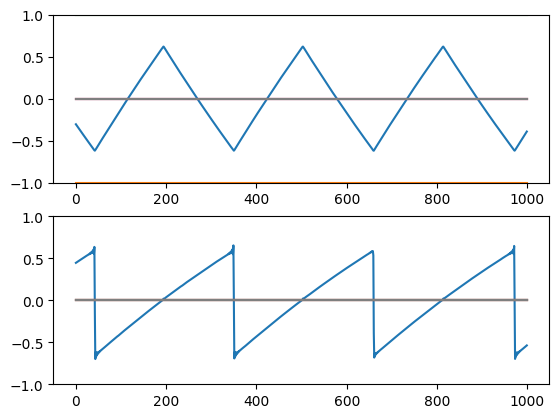

In [389]:
for i in range(len(x)):
    fig.clf()
    fig, (ax1, ax2) = plt.subplots(2)
    print(i, x[i][:5])
    ax1.plot(x[i])
    ax2.plot(y[i])
    ax1.set_ylim((-1, 1))
    ax2.set_ylim((-1, 1))
    plt.savefig(f"foo_{i:03d}.png")



we want to rebuild the dataset from tri, sine, ramp and tri, square, zigzag
to (embed0, embed1, tri) -> one of the other waves


In [260]:
x = [1,2,3,4]

[x[0]]*5 + x

[1, 1, 1, 1, 1, 1, 2, 3, 4]

In [5]:
data = tsr_df_w.to_numpy().astype(np.float32)

tri_to = {}
tri_to['sine'] = {}
tri_to['sine']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['sine']['x'][:,0] = 0  # x2
tri_to['sine']['x'][:,1] = 0  # x3
tri_to['sine']['x'][:,2] = data[:,0] # triangle
tri_to['sine']['y'] = np.expand_dims(data[:,1], -1) # sine

tri_to['ramp'] = {}
tri_to['ramp']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['ramp']['x'][:,0] = 0  # x2
tri_to['ramp']['x'][:,1] = 1  # x3
tri_to['ramp']['x'][:,2] = data[:,0] # triangle
tri_to['ramp']['y'] = np.expand_dims(data[:,2], -1) # ramp

data = tsz_df_w.to_numpy().astype(np.float32)

tri_to['square'] = {}
tri_to['square']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['square']['x'][:,0] = 1  # x2
tri_to['square']['x'][:,1] = 0  # x3
tri_to['square']['x'][:,2] = data[:,0] # triangle
tri_to['square']['y'] = np.expand_dims(data[:,1], -1) # square

tri_to['zigzag'] = {}
tri_to['zigzag']['x'] = np.empty((len(data), 3), dtype=np.float32)
tri_to['zigzag']['x'][:,0] = 1  # x2
tri_to['zigzag']['x'][:,1] = 1  # x3
tri_to['zigzag']['x'][:,2] = data[:,0] # triangle
tri_to['zigzag']['y'] = np.expand_dims(data[:,2], -1) # zigzag


In [6]:
def split_train_val_test(d):
    assert 'x' in d
    assert 'y' in d
    assert len(d['x']) == len(d['y'])
    val_test_split_size = int(len(d['x']) * 0.1)  # 10% for val and test
    d['train'] = {}
    d['validate'] = {}
    d['test'] = {}
    for xy in ['x', 'y']:                
        d['train'][xy] = d[xy][:-2*val_test_split_size]        
        d['validate'][xy] = d[xy][-2*val_test_split_size:-val_test_split_size]        
        d['test'][xy] = d[xy][-val_test_split_size:]
        d.pop(xy)

for wave in ['sine', 'ramp', 'square', 'zigzag']:
    split_train_val_test(tri_to[wave])

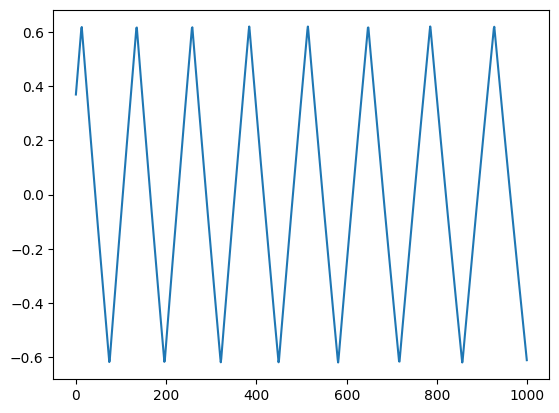

In [7]:
plt.plot(data[:,0][1000:2000])

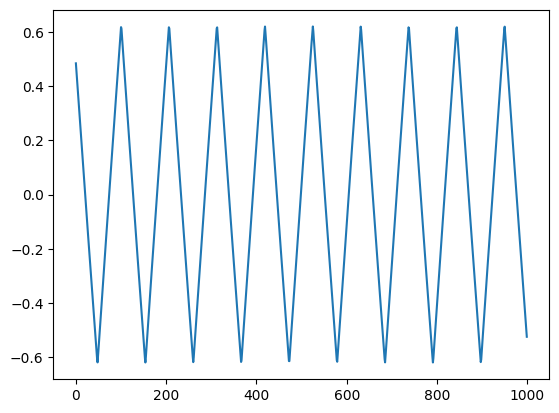

In [8]:
plt.plot(tri_to['ramp']['train']['x'][:,2][1000:2000])

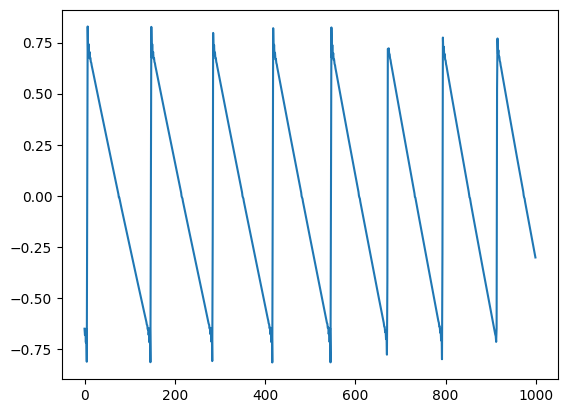

In [9]:
plt.plot(tri_to['ramp']['validate']['y'][1000:2000])

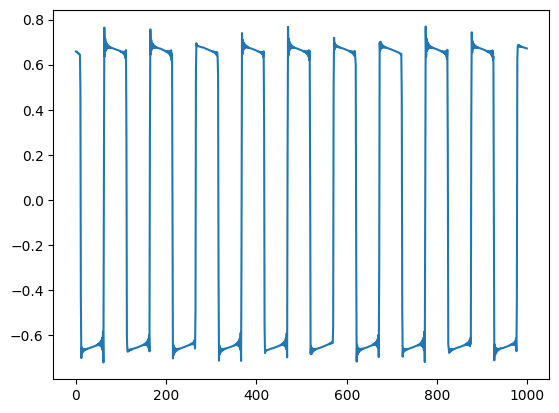

In [10]:
plt.plot(tri_to['square']['test']['y'][1000:2000])

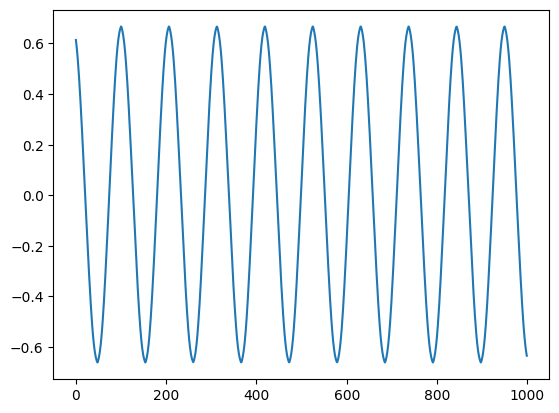

In [11]:
plt.plot(tri_to['sine']['train']['y'][1000:2000])

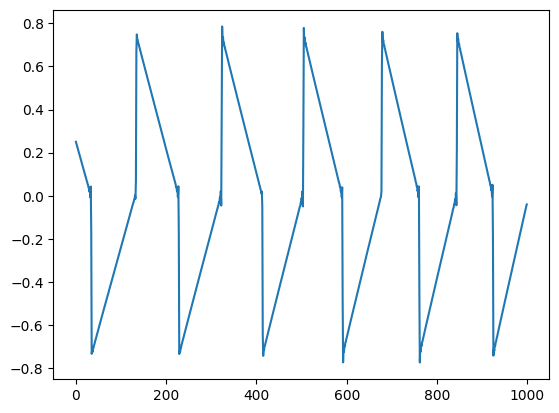

In [12]:
plt.plot(tri_to['zigzag']['validate']['y'][1000:2000])

In [13]:
IN_D = 3    # 2d embedding, (0,1) and core triangle
OUT_D = 1   # output wave

# kernel size and implied dilation rate
K = 4                

# filters for Nth layer Kx1 and 1x1 convs
# [4, 3, 8, 8] @ 32kHz => 72%
# [4, 8, 8, 8] @ 32kHz => 82%
# [4, 8, 8, 12] @ 32kHz => 93%
# [8, 8, 8, 8] @ 32kHz => TOO MUCH
# [4, 4, 4] @ 96kHz => too much :/
# [2, 2, 4] @ 96kHz => too much :/
# [2, 2, 2] @ 96kHz => too much :/

FILTER_SIZES = [4, 4, 4, 4]

RECEPTIVE_FIELD_SIZE = K**len(FILTER_SIZES)

TEST_SEQ_LEN = RECEPTIVE_FIELD_SIZE
TRAIN_SEQ_LEN = RECEPTIVE_FIELD_SIZE * 5

print("RECEPTIVE_FIELD_SIZE", RECEPTIVE_FIELD_SIZE)
print("TRAIN_SEQ_LEN", TRAIN_SEQ_LEN)
print("TEST_SEQ_LEN", TEST_SEQ_LEN)

RECEPTIVE_FIELD_SIZE 256
TRAIN_SEQ_LEN 1280
TEST_SEQ_LEN 256


In [15]:
from tensorflow.keras.optimizers import Adam

def masked_mse(y_true, y_pred):    
    assert len(y_true.shape) == 3, "expected (batch, sequence_length, output_dim)"
    assert y_true.shape == y_pred.shape
    
    # average over elements of y
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)  
    
    # we want to ignore the first RECEPTIVE_FIELD_SIZE elements of the loss since they 
    # have been fed with left padded data
    mse = mse[:,RECEPTIVE_FIELD_SIZE:]     

    # return average over batch and sequence
    return tf.reduce_mean(mse)
    
def dataset_from(x, y, s):
    def gen():
        idxs = list(range(len(x)-TRAIN_SEQ_LEN-1))  # ~1.3M
        random.Random(1337).shuffle(idxs)
        if s == 'train':            
            idxs = idxs[:20_000]   # 200_000
        else:
            idxs = idxs[:500]   # 5_000
        for i in idxs:
            yield x[i:i+TRAIN_SEQ_LEN], y[i+1:i+1+TRAIN_SEQ_LEN]
                
    ds = tf.data.Dataset.from_generator(
        gen, output_signature=(tf.TensorSpec(shape=(TRAIN_SEQ_LEN, IN_D), dtype=tf.float32),
                               tf.TensorSpec(shape=(TRAIN_SEQ_LEN, OUT_D), dtype=tf.float32)))
    return ds

def datasets_for_split(s):
    return  [
        dataset_from(tri_to[wave][s]['x'], tri_to[wave][s]['y'], s) #.cache() #filename=f"tf_data_cache_{wave}")
        for wave in ['sine', 'ramp', 'square', 'zigzag']  
    ] 
    
train_ds = tf.data.Dataset.sample_from_datasets(datasets_for_split('train'))
train_ds = train_ds.batch(128).prefetch(tf.data.AUTOTUNE)

validate_ds = tf.data.Dataset.sample_from_datasets(datasets_for_split('validate'))
validate_ds = validate_ds.batch(128).prefetch(tf.data.AUTOTUNE)